##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 転移学習とファインチューニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/transfer_learning.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、転移学習を使用して、事前トレーニング済みネットワークから猫や犬の画像を分類する方法を紹介します。

事前トレーニング済みモデルは、通常は大規模な画像分類タスクなどの大規模なデータセットで事前トレーニング済みの保存されたネットワークです。事前トレーニング済みモデルをそのまま使用したり、転移学習を使用してこのモデルを任意のタスクにカスタマイズしたりすることができます。

画像分類のための転移学習の背後にある考え方は、モデルが大規模かつ十分に一般的なデータセットでトレーニングされていれば、そのモデルは視覚世界の一般的なモデルとして効果的に機能するというものです。それにより、最初から大規模なデータセット上で大規模なモデルをトレーニングを行わずに、これらの学習した特徴マップを活用することができます。

このノートブックでは、トレーニング済みモデルをカスタマイズする 2 つの方法を試します。

1. 特徴抽出：前のネットワークで学習した表現を使用して、新しいサンプルから意味のある特徴を抽出します。事前トレーニング済みモデルの上に新規にトレーニングされる新しい分類器を追加するだけで、データセットで前に学習した特徴マップを再利用できるようになります。

モデル全体を（再）トレーニングする必要はありません。ベースとなる畳み込みネットワークには、画像分類に一般的に有用な特徴がすでに含まれています。ただし、事前トレーニング済みモデルの最後の分類部分は元の分類タスクに固有で、その後はモデルがトレーニングされたクラスのセットに固有です。

1. ファインチューニング：凍結された基本モデルの最上位レイヤーのいくつかを解凍し、新たに追加された分類器レイヤーと解凍した基本モデルの最後のレイヤーの両方を合わせてトレーニングします。これにより、基本モデルの高次の特徴表現を「ファインチューニング」して、特定のタスクにより関連性を持たせることができます。

一般的な機械学習のワークフローに従います。

1. データを調べ、理解する
2. 入力パイプラインを構築し、この場合は Keras ImageDataGenerator を使用する
3. モデルを作成する
    - 事前トレーニング済みの基本モデル（および事前トレーニング済みの重み）を読み込む
    - 分類レイヤーを上に重ねる
4. モデルをトレーニングする
5. モデルを評価する


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## データの前処理をする

### データをダウンロードする

このチュートリアルでは、数千枚の犬猫の画像を含むデータセットを使用します。画像を含む zip ファイルをダウンロードして解凍した後、`tf.keras.utils.image_dataset_from_directory` ユーティリティを使用して `tf.data.Dataset` を作成し、トレーニングと検証を行います。画像の読み込みに関する詳細は、この[チュートリアル](https://www.tensorflow.org/tutorials/load_data/images)をご覧ください。

In [56]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [57]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


トレーニングセットの最初の 9 枚の画像とラベルを表示します。

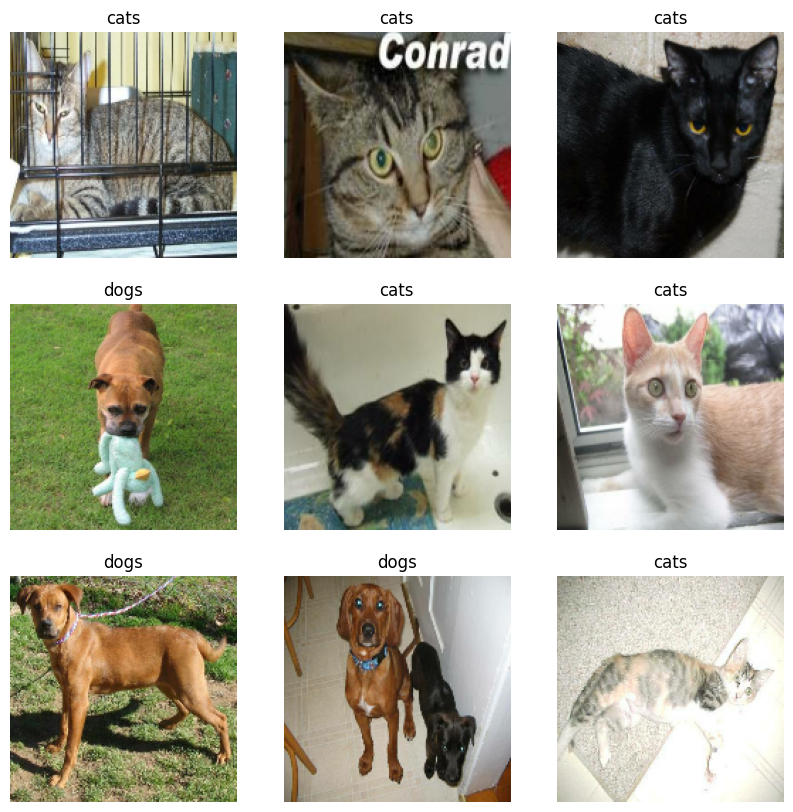

In [58]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

元のデータセットにはテストセットが含まれていないので、テストセットを作成します。作成には、`tf.data.experimental.cardinality` を使用して検証セットで利用可能なデータのバッチ数を調べ、そのうちの 20％ をテストセットに移動します。

In [59]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [60]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### パフォーマンスのためにデータセットを構成する

バッファ付きプリフェッチを使用して、I/O のブロッキングなしでディスクから画像を読み込みます。この手法の詳細については[データパフォーマンス](https://www.tensorflow.org/guide/data_performance)ガイドをご覧ください。

In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### データ増強を使用する

大規模な画像データセットを持っていない場合には、回転や水平反転など、ランダムでありながら現実的な変換をトレーニング画像に適用し、サンプルを人為的に多様化することをお勧めします。これによって、トレーニングデータのさまざまな側面にモデルを露出させることができ、[過適合](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)を遅らせることができます。データ増強についての詳細は、この[チュートリアル](https://www.tensorflow.org/tutorials/images/data_augmentation)をご覧ください。

In [62]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

注意: これらのレイヤーは、トレーニング中に `Model.fit` を呼び出した場合にのみアクティブです。モデルが `Model.evaluate`、`Model.predict`、または `Model.call` の推論モードで使用されている場合には非アクティブです。

これらのレイヤーを同じ画像に繰り返して適用し、結果を見てみましょう。

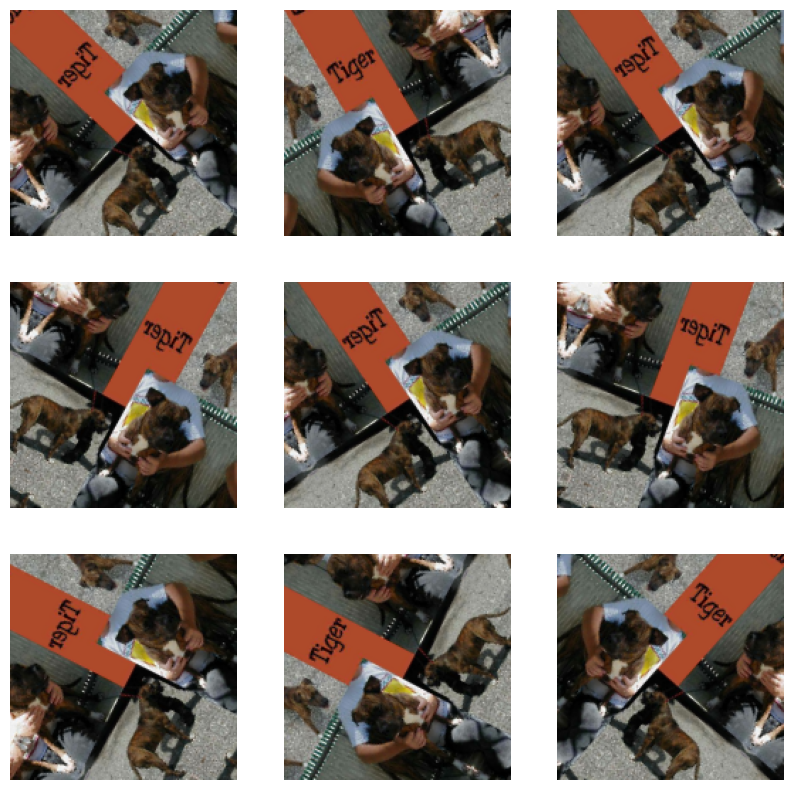

In [63]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### ピクセル値をリスケールする

すぐに `tf.keras.applications.MobileNetV2` をダウンロードして、基本モデルとして使用します。このモデルはピクセル値 `[-1,1]` を想定していますが、この時点での画像のピクセル値は `[0, 255]` です。ピクセル値のリスケールには、モデルに含まれる前処理のメソッドを使用します。

In [64]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

注意: 別の方法として、`tf.keras.layers.Rescaling` を使用して、ピクセル値を `[0, 255]` から `[-1, 1]` にリスケールすることも可能です。

In [65]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

注意: 他の `tf.keras.applications` を使用する場合は、API ドキュメントを確認してピクセル値が `[-1,1]` または `[0,1]` を要求しているか確かめるか、あるいは含まれている関数 `preprocess_input` を使用します。

## 事前トレーニング済み畳み込みニューラルネットワークから基本モデルを作成する

Google が開発した **MobileNet V2** モデルから基本モデルを作成します。これは、140 万枚の画像と 1000 クラスで構成された大規模データセットである ImageNet データセットによる事前トレーニング済みのモデルです。ImageNet は、`jackfruit` や `syringe` のような多彩なカテゴリを持つ研究用トレーニングデータセットです。この知識の基盤が、特定のデータセットから猫と犬を分類するのに有用になります。

まず、特徴抽出に使用する MobileNet V2 のレイヤーを選択する必要があります。最後の分類レイヤー（ほとんどの機械学習モデルの図では、下から上に向かうため、「上」にあります）はあまり役には立ちません。 その代わりに、平坦化演算の前の最後のレイヤーに依存するのが一般的です。このレイヤーは「ボトルネックレイヤー」と呼ばれます。ボトルネックレイヤーの特徴には、最終/最上位レイヤーよりも一般性が保持されています。

はじめに、ImageNet でトレーニングした重みで事前に読み込んだ MobileNet V2 モデルをインスタンス化します。引数 **include_top=False** を指定して、上位の分類レイヤーを含まない、特徴抽出に理想的なネットワークを読み込みます。

In [66]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

この特徴抽出器は、各 `160x160x3` の画像を `5x5x1280` の特徴ブロックに変換します。 これで画像のバッチ例がどうなるかを見てみましょう。

In [67]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 特徴を抽出する

このステップでは、前のステップで作成した畳み込みベースを凍結させ、特徴抽出器として使用します。さらに、その上に分類器を追加して、最上位の分類器のトレーニングを行います。

### 畳み込みベースを凍結させる

モデルをコンパイルしてトレーニングする前に、畳み込みベースを凍結させることは重要です。(layer.trainable = False と設定して) 凍結させると、トレーニング中に特定のレイヤーの重みは更新されなくなります。MobileNet V2 には多くのレイヤーがありますが、モデル全体の `trainable` フラグを False に設定すれば、すべてのレイヤーをまとめて凍結することができます。

In [68]:
base_model.trainable = False

### BatchNormalization レイヤーに関する重要な注意事項

多くのモデルには `tf.keras.layers.BatchNormalization` レイヤーが含まれています。このレイヤーは特殊なケースで、ファインチューニングのコンテキストに注意を払う必要があります。このチュートリアルでも後ほど説明します。

`layer.trainable = False` と設定する場合、`BatchNormalization` レイヤーは推論モードで実行されるため、その平均と分散統計は更新されません。

ファインチューニングを行うために BatchNormalization（バッチ正規化）レイヤーを含んだモデルを解凍する場合には、基本モデルを呼び出す際に `training = False` を渡して BatchNormalization レイヤーを推論モードにしておく必要があります。そうしないと、トレーニング不可能な重みに更新が適用され、モデルが学習したものを破壊してしまいます。

詳細については、[転移学習ガイド](https://www.tensorflow.org/guide/keras/transfer_learning)をご覧ください。

In [69]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### 分類ヘッドを追加する

特徴ブロックから予測値を生成するには、`f.keras.layers.GlobalAveragePooling2D` レイヤーを使用して `5x5` 空間の空間位置を平均化し、特徴を画像ごとに単一の1280要素ベクトルに変換します。

In [70]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


`tf.keras.layers.Dense` レイヤーを適用して、これらの特徴を画像ごとに単一の予測値に変換します。この予測は `logit` または未加工の予測値として扱われるため、ここで活性化関数は必要ありません。 正の数はクラス 1 を予測し、負の数はクラス 0 を予測します。

In [71]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


[Keras Functional API](https://www.tensorflow.org/guide/keras/functional) を使用して、データ増強、リスケール、base_model、特徴抽出レイヤーを連結してモデルを構築します。前に触れたように、モデルには BatchNormalization レイヤーが含まれているため、training=False を使用します。

In [72]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [73]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNet の 800 万個以上のパラメータは凍結されていますが、Dense レイヤーには 1200 個の*トレーニング可能な*パラメータがあります。これらは 2 つの `tf.Variable` オブジェクトである、重みとバイアスに分割されます。

In [74]:
len(model.trainable_variables)

2

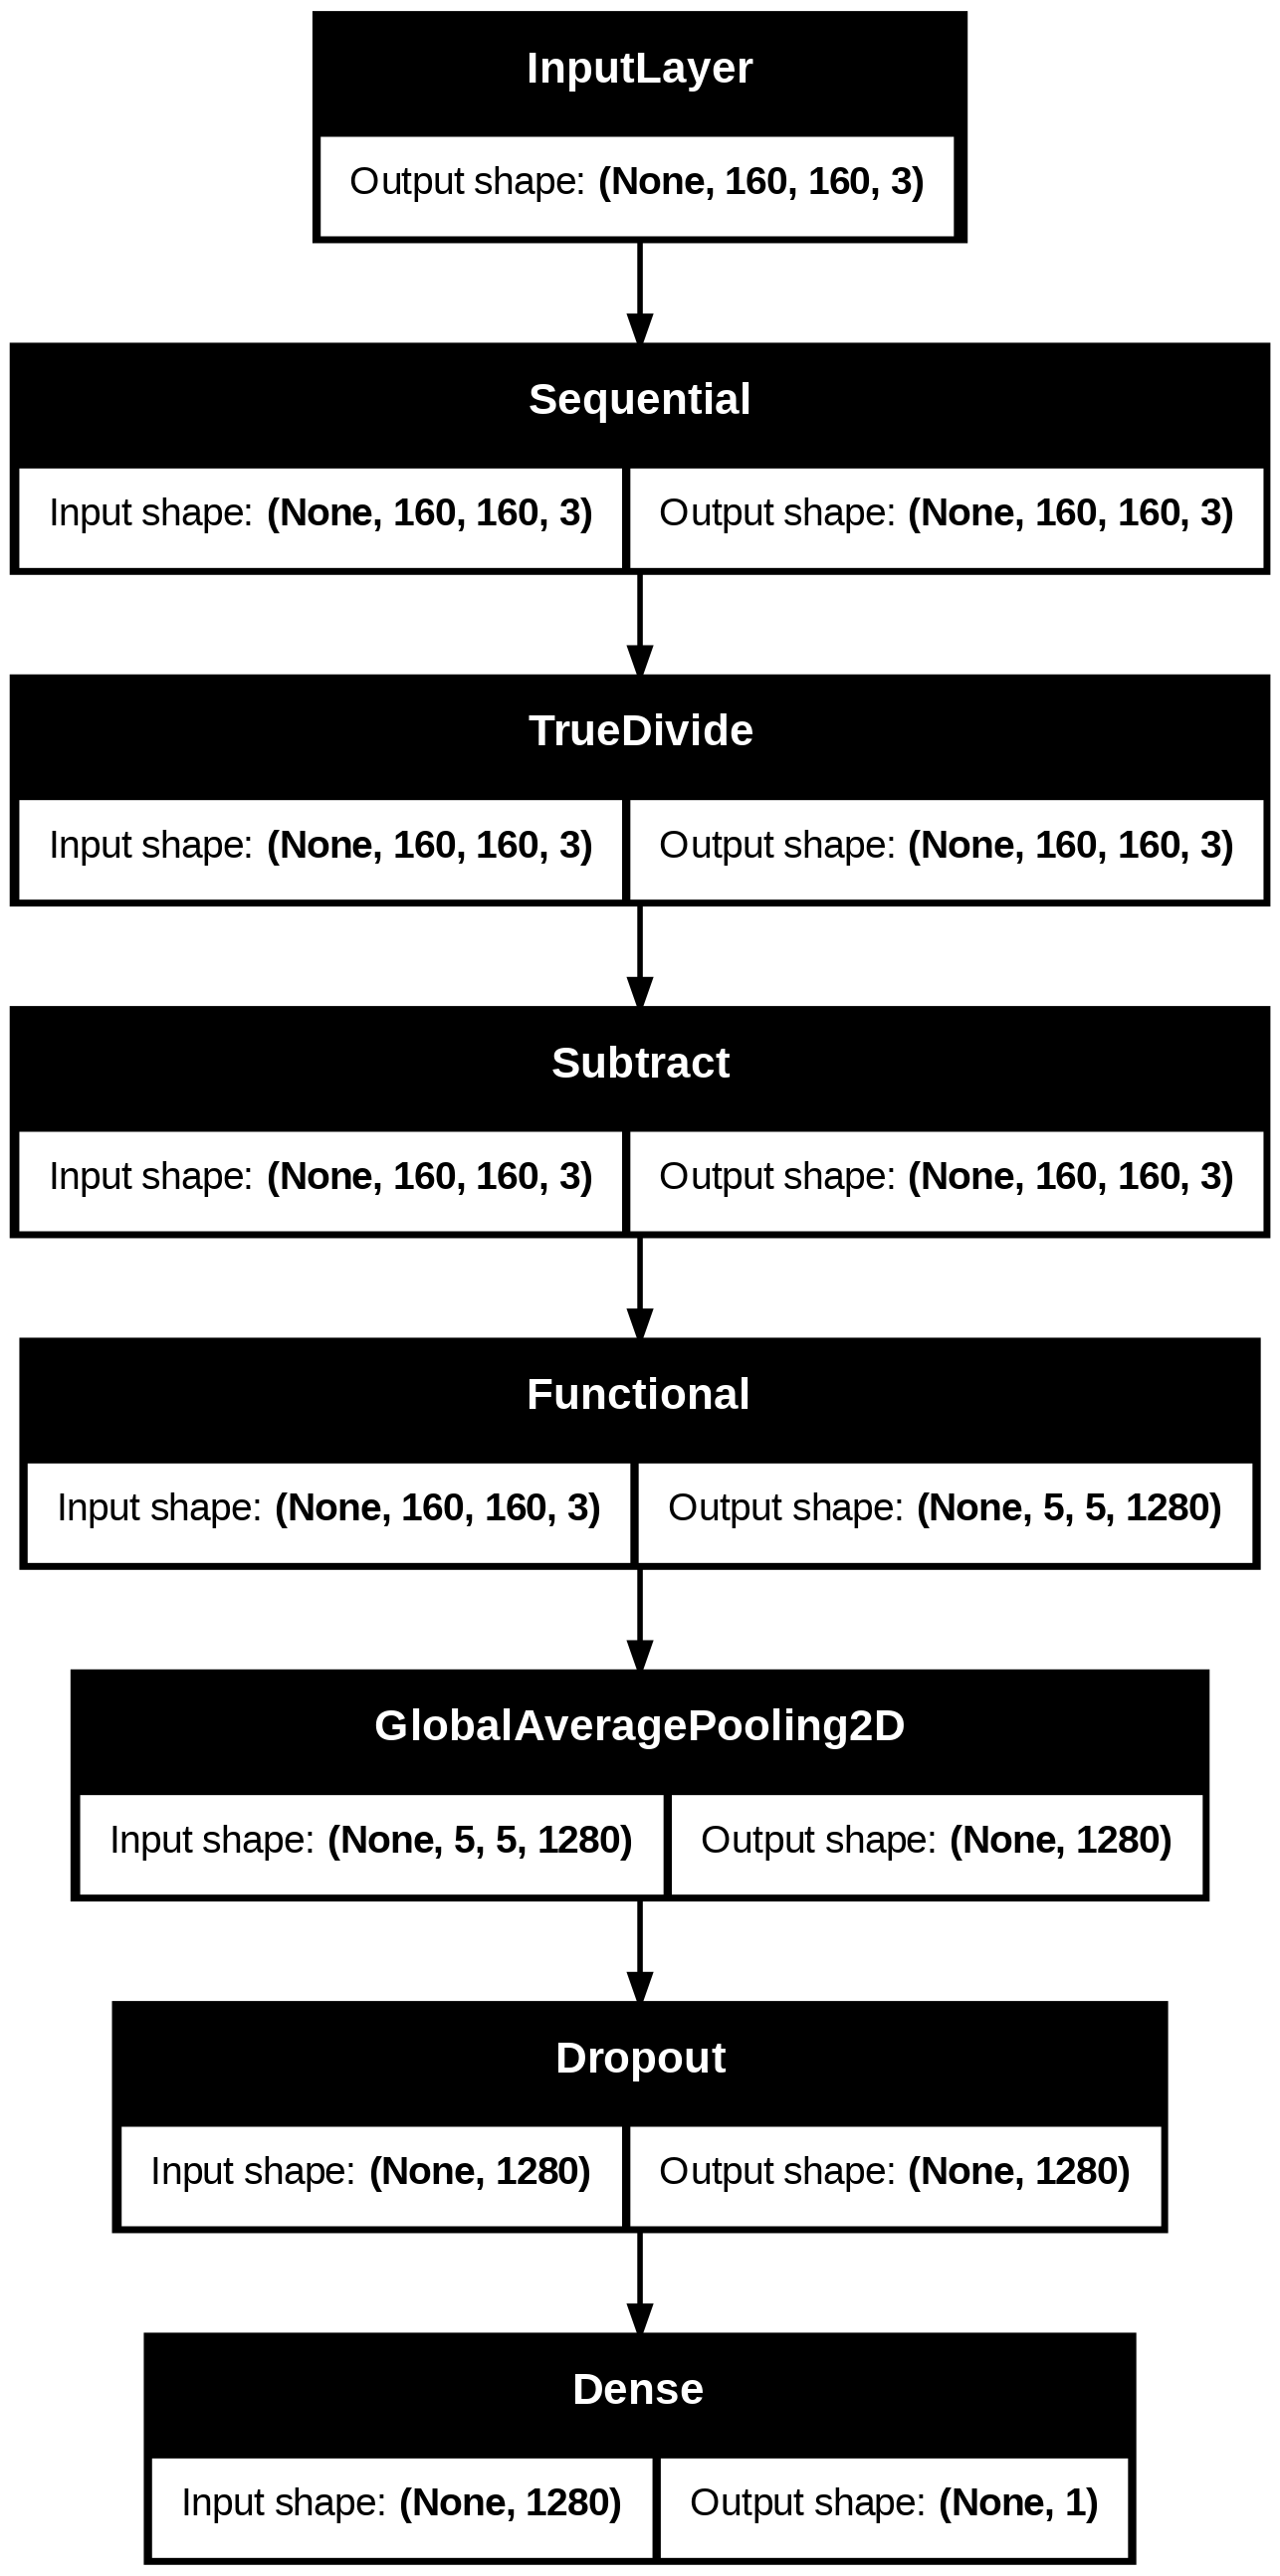

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True)

### モデルをコンパイルする

トレーニングする前にモデルをコンパイルします。2 つのクラスがあり、モデルが線形出力を提供するので、`from_logits=True` で `tf.keras.losses.BinaryCrossentropy` を使用します。

In [76]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### モデルをトレーニングする

10 エポックのトレーニング後は、検証セットの精度が最大 96%になります。


In [77]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6396 - loss: 0.6722


In [78]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.64


In [79]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6566 - loss: 0.6506 - val_accuracy: 0.8366 - val_loss: 0.4376
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.7761 - loss: 0.4891 - val_accuracy: 0.9084 - val_loss: 0.3231
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8392 - loss: 0.4076 - val_accuracy: 0.9356 - val_loss: 0.2531
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8771 - loss: 0.3294 - val_accuracy: 0.9542 - val_loss: 0.2131
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8897 - loss: 0.3010 - val_accuracy: 0.9592 - val_loss: 0.1796
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8995 - loss: 0.2664 - val_accuracy: 0.9641 - val_loss: 0.1604
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8952 - loss: 0.2528 - val_accuracy: 0.9678 - val_loss: 0.1450
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9121 - loss: 0.2284 - val_accuracy: 0.9703 - v

### 学習曲線

MobileNet V2 基本モデルを固定の特徴抽出器として使用する場合の、トレーニングと検証それぞれの精度と損失の学習曲線を見てみましょう。

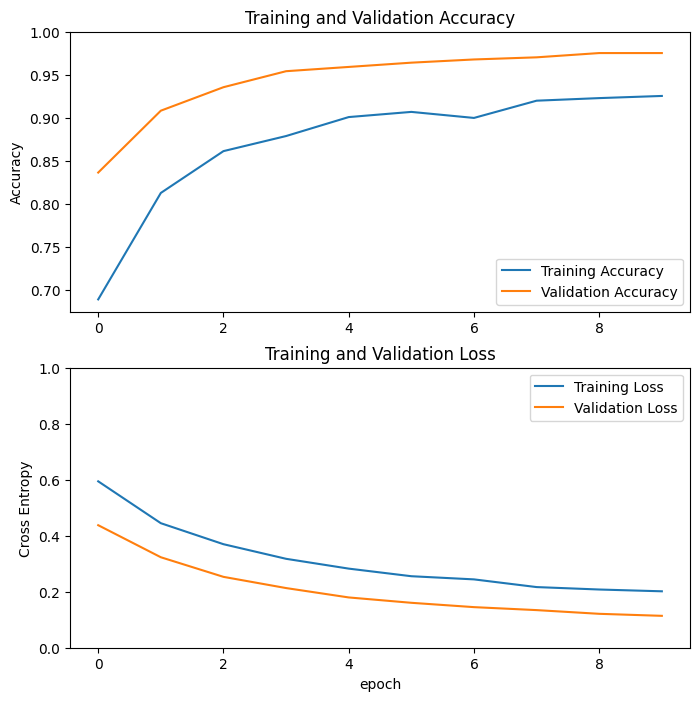

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

注意: 明らかに検証指標がトレーニング指標よりも優れていることを疑問に思われるかもしれませんが、それはトレーニング中に `tf.keras.layer.BatchNormalization` や `tf.keras.layer.Dropout` などのレイヤーが精度に影響を与えていることが主な要因です。検証損失の計算時には、これらのレイヤーはオフになっています。

また、上記の要因ほどではないにせよトレーニング指標がエポックの平均を報告する一方で検証指標がエポック後に評価されるため、検証指標の方が少しだけ長い時間トレーニングされたモデルを参照しているという理由もあります。

## ファインチューニング

特徴抽出の実験では、MobileNet V2 基本モデル上に少数のレイヤーを重ねてトレーニングをしたに過ぎませんでした。事前トレーニング済みネットワークの重みはトレーニング中に更新**されません**。

パフォーマンスをさらに向上させる方法の 1 つに、追加した分類器のトレーニングと並行して、事前トレーニング済みモデルの最上位レイヤーの重みをトレーニング（または「ファインチューニング」）するというものがあります。トレーニングのプロセスでは、一般的な特徴マップから特にデータセットに関連付けられた特徴に、強制的に重みをチューニングします。

注意: これは必ず、事前トレーニング済みモデルをトレーニング不可に設定し、最上位の分類器をトレーニングした後に行うようにしてください。事前トレーニング済みモデルの上にランダムに初期化された分類器を追加してすべてのレイヤーを結合トレーニングしようとすると、（分類器からのランダムな重みにより）勾配の更新規模が大きすぎて、事前トレーニング済みモデルが学習したことを忘れてしまいます。

また、MobileNet モデル全体ではなく、少数の最上位レイヤーをファインチューニングしてみることをお勧めします。大部分の畳み込みネットワークでは、上位のレイヤーに行くほど専門性が高くなります。最初の数レイヤーは、ほとんどすべてのタイプの画像に一般化する、非常に単純かつ一般的な特徴を学習します。上位のレイヤーに行くに従って、特徴はモデルがトレーニングされたデータセットに対してもっと固有なものになっていきます。ファインチューニングの目的は、一般的な学習を上書きするのではなく、これらの特殊な特徴に適応させて新しいデータセットで作業ができるようにすることです。

### モデルの最上位レイヤーを解凍する


ここでは `base_model` を解凍して、最下位レイヤーをトレーニング不可設定にするだけです。その後、モデルを再コンパイルして（これは行った変更を有効化するために必要）、トレーニングを再開します。

In [81]:
base_model.trainable = True

In [82]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### モデルをコンパイルする

かなり大規模なモデルをトレーニングしているため、事前トレーニング済みの重みを再適用する場合は、この段階では低い学習率を使用することが重要です。そうしなければ、モデルがすぐに過適合を起こす可能性があります。

In [83]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [84]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [85]:
len(model.trainable_variables)

56

### モデルのトレーニングを続ける

前に収束するようにトレーニングをした場合は、このステップを踏むと精度が数ポイント向上します。

In [86]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.8046 - loss: 0.3947 - val_accuracy: 0.9715 - val_loss: 0.0851
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8773 - loss: 0.2756 - val_accuracy: 0.9765 - val_loss: 0.0742
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9203 - loss: 0.2191 - val_accuracy: 0.9814 - val_loss: 0.0638
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9277 - loss: 0.1799 - val_accuracy: 0.9839 - val_loss: 0.0579
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9251 - loss: 0.1817 - val_accuracy: 0.9839 - val_loss: 0.0516
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9359 - loss: 0.1720 - val_accuracy: 0.9839 - val_loss: 0.0465
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9433 - loss: 0.1383 - val_accuracy: 0.9851 - val_loss: 0.0449
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9464 - loss: 0.1332 - val_accuracy: 

MobileNet V2 基本モデルの最後の数レイヤーをファインチューニングし、その上で分類器をトレーニングした場合の、トレーニングと検証それぞれの精度と損失の学習曲線を見てみましょう。検証損失の曲線がトレーニング損失よりもはるかに高いため、多少の過適合が発生する可能性があります。

また、新しいトレーニングセットが比較的小規模で、元の MobileNet V2 データセットに似ているために、過適合が発生する場合があります。


モデルをファインチューニングした後は、検証セットの精度はほぼ 98%に達します。

In [87]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

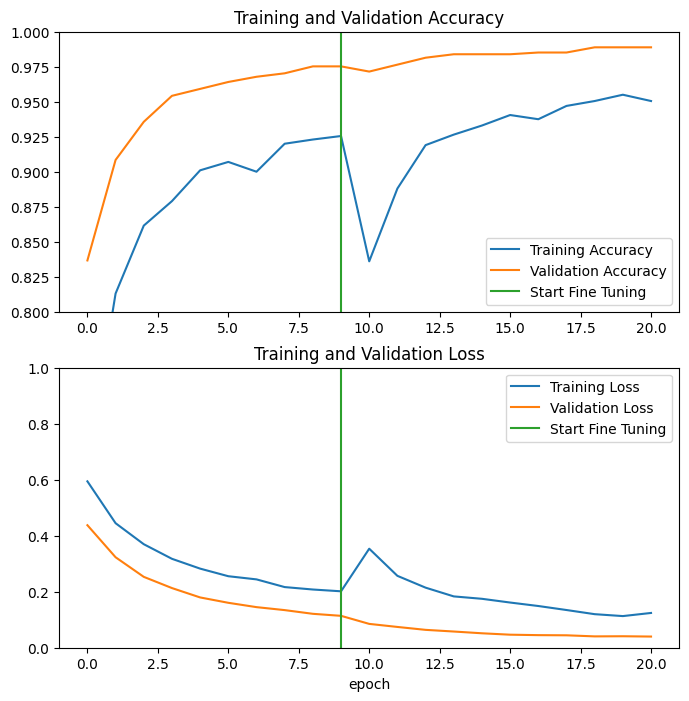

In [88]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 評価と予測をする

最後に、テストセットを使用して、新しいデータでモデルの性能を検証することができます。

In [89]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9883 - loss: 0.0456
Test accuracy : 0.9947916865348816


これで、このモデルを使用してペットが猫か犬かを予測する準備がすべて整いました。

Predictions:
 [0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1]
Labels:
 [0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1]


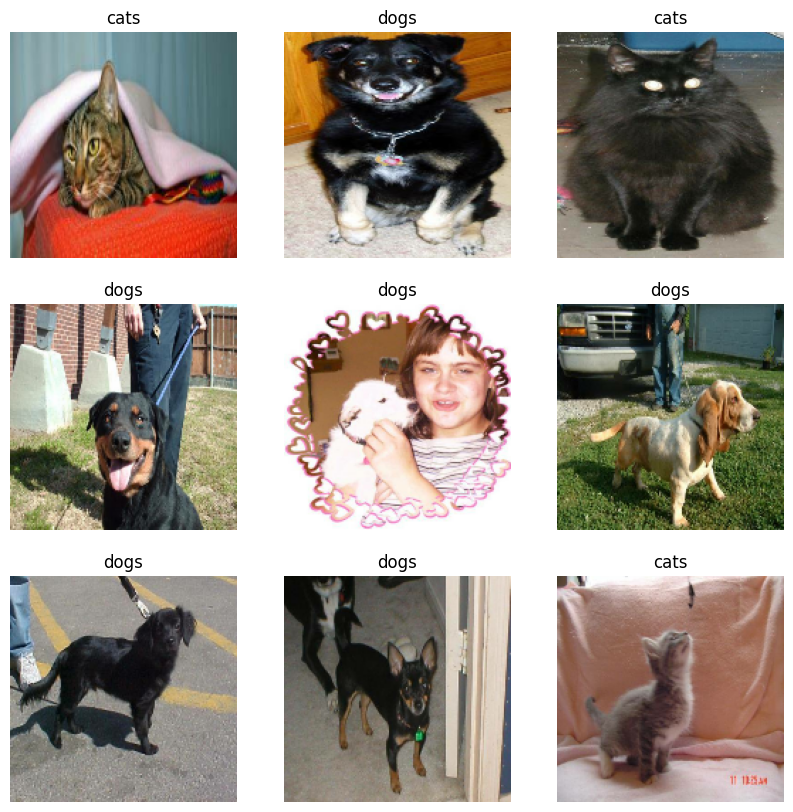

In [90]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [107]:
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
# y_test を作成する
y_test = []

# test_dataset からラベルを収集
for _, label_batch in test_dataset:
    y_test.extend(label_batch.numpy())

# numpy 配列に変換
y_test = np.array(y_test)


In [93]:
print(y_test)

[0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0
 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1
 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0
 1 1 1 0 1 1 1]


In [101]:
y_pred = []

# test_dataset から画像を取得し、予測を行う
for image_batch, _ in test_dataset:
    # モデルで予測
    predictions = model.predict(image_batch)

    # シグモイド関数を適用して確率を取得
    predictions = tf.nn.sigmoid(predictions).numpy().flatten()

    # 閾値を使ってクラス分類（0: Negative, 1: Positive）
    predictions = (predictions >= 0.5).astype(int)

    # 予測をリストに追加
    y_pred.extend(predictions)

# numpy 配列に変換
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [102]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [103]:
print(cm)

[[58 43]
 [48 43]]


In [104]:
# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
print(df_cm)


                 predict_Positive  predict_Negative
actual_Positive                43                48
actual_Negative                43                58


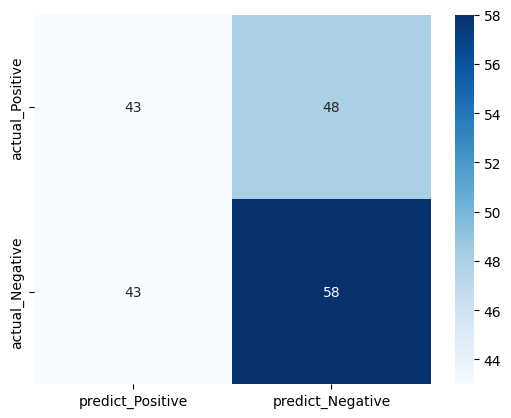

In [105]:
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')
plt.show()

In [108]:
recall = recall_score(y_test, y_pred)

In [113]:
#再現率
print(recall)

0.4725274725274725


## 要約

- **特徴抽出に事前トレーニング済みモデルを使用する**:  小さなデータセットで作業する場合は、より大規模な同じドメインのデータセットでトレーニングされたモデルが学習した特徴を利用するのが一般的です。これは、事前トレーニング済みモデルをインスタンス化し、その上に完全に接続された分類器を追加して行います。事前トレーニング済みモデルは「凍結」されているため、トレーニング中は分類器の重みだけを更新します。この場合、畳み込みベースは各画像に関連付けられたすべての特徴を抽出し、抽出された特徴量のセットから画像クラスを決定する分類器をトレーニングします。

- **事前トレーニング済みモデルをファインチューニングする**: 性能をさらに向上させるために、事前トレーニング済みモデルの最上位レイヤーをファインチューニングして、新しいデータセットに再利用することができます。この場合は、データセット固有の高レベルの特徴をモデルが学習するように重みをチューニングします。この手法は、通常はトレーニングデータセットが大規模で、事前トレーニング済みモデルがトレーニングされた元のデータセットによく似ている場合に推奨されます。

さらに詳しくは[転移学習ガイド](https://www.tensorflow.org/guide/keras/transfer_learning)をご覧ください。
